In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RandomizedSearchCV

from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import mean_squared_error

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import vstack, issparse

pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv('data/dataset_workout.csv')
df.head(3)

,Gender,Weight (kg),Height (m),Workout_Type,Workout_Frequency (days),BMI,Daily meals frequency,diet_type,rating,Name of Exercise,Sets,Reps,Benefit,Target Muscle Group,Equipment Needed,Body Part,Type of Muscle,Workout,cluster_id,E,I,workload,S,D,R
0,Male,65.27,1.62,Strength,4,24.87,3,Vegan,1.31,Decline Push-ups,5,21,Improves shoulder health and posture,"Shoulders, Triceps",Cable Machine,Legs,Lats,Dumbbell flyes,2,0.570217,0.526466,105,0.250000,0.333333,0.637310
1,Female,56.41,1.55,HIIT,4,23.48,3,Vegetarian,1.92,Bear Crawls,4,16,Strengthens lower abs,"Back, Core, Shoulders",Step or Box,Chest,Lats,Lateral raises,2,0.740993,0.256055,64,0.225000,0.575163,0.862514
2,Female,58.98,1.67,Cardio,3,21.15,2,Paleo,4.70,Dips,5,22,Builds chest strength,"Quadriceps, Glutes",Step or Box,Arms,Grip Strength,Standing calf raises,1,0.549660,0.289199,110,0.416667,0.274510,0.685580


In [3]:
user = pd.read_csv('data/new_user.csv')
user 

,Age,Gender,Weight (kg),Height (m),BMI,Experience_Level,Workout_Frequency (days),Daily meals frequency,diet_type,Goal,WeightChange (kg),GoalDays,cluster_id,BMR,PAL,TDEE,CalorieChange,CaloriesToBurnTraining,CaloriesReducedFromFood,CaloriesPerDay,TotalWorkouts,CaloriesPerWorkout
0,22,Male,88.0,1.8,27.160494,2,3,3,Keto,Maintain,3.0,30,0,1900.0,1.725,3277.5,23100.0,11550.0,11550.0,3277.5,12.857143,898.333333


### Target calculation depending on goal from user

In [4]:
goal = user['Goal'].iloc[0]

if goal == 'Loss':
    df['target'] = 0.45*df['E'] + 0.25*df['I'] + 0.10*df['D'] + 0.05*df['S'] + 0.15*df['R']
elif goal == 'Maintain':
    df['target'] = 0.25*df['E'] + 0.20*df['I'] + 0.15*df['D'] + 0.20*df['S'] + 0.20*df['R']
elif goal == 'Gain':
    df['target'] = 0.05*df['E'] + 0.15*df['I'] + 0.10*df['D'] + 0.50*df['S'] + 0.20*df['R']
else:
    raise ValueError("Goal must be one of: 'Loss', 'Maintain', 'Gain'")

In [5]:
df.head(3)

,Gender,Weight (kg),Height (m),Workout_Type,Workout_Frequency (days),BMI,Daily meals frequency,diet_type,rating,Name of Exercise,Sets,Reps,Benefit,Target Muscle Group,Equipment Needed,Body Part,Type of Muscle,Workout,cluster_id,E,I,workload,S,D,R,target
0,Male,65.27,1.62,Strength,4,24.87,3,Vegan,1.31,Decline Push-ups,5,21,Improves shoulder health and posture,"Shoulders, Triceps",Cable Machine,Legs,Lats,Dumbbell flyes,2,0.570217,0.526466,105,0.250000,0.333333,0.637310,0.475309
1,Female,56.41,1.55,HIIT,4,23.48,3,Vegetarian,1.92,Bear Crawls,4,16,Strengthens lower abs,"Back, Core, Shoulders",Step or Box,Chest,Lats,Lateral raises,2,0.740993,0.256055,64,0.225000,0.575163,0.862514,0.540237
2,Female,58.98,1.67,Cardio,3,21.15,2,Paleo,4.70,Dips,5,22,Builds chest strength,"Quadriceps, Glutes",Step or Box,Arms,Grip Strength,Standing calf raises,1,0.549660,0.289199,110,0.416667,0.274510,0.685580,0.456880


### Training dataset preparation

In [6]:
df = df.drop(columns=['E', 'I', 'D', 'S', 'R'])
df.head(3)

,Gender,Weight (kg),Height (m),Workout_Type,Workout_Frequency (days),BMI,Daily meals frequency,diet_type,rating,Name of Exercise,Sets,Reps,Benefit,Target Muscle Group,Equipment Needed,Body Part,Type of Muscle,Workout,cluster_id,workload,target
0,Male,65.27,1.62,Strength,4,24.87,3,Vegan,1.31,Decline Push-ups,5,21,Improves shoulder health and posture,"Shoulders, Triceps",Cable Machine,Legs,Lats,Dumbbell flyes,2,105,0.475309
1,Female,56.41,1.55,HIIT,4,23.48,3,Vegetarian,1.92,Bear Crawls,4,16,Strengthens lower abs,"Back, Core, Shoulders",Step or Box,Chest,Lats,Lateral raises,2,64,0.540237
2,Female,58.98,1.67,Cardio,3,21.15,2,Paleo,4.70,Dips,5,22,Builds chest strength,"Quadriceps, Glutes",Step or Box,Arms,Grip Strength,Standing calf raises,1,110,0.456880


In [7]:
# =========================
# 3) Split X/y (Train / Val / Test)
# =========================
X = df.drop(columns=["target"])
y = df["target"]

# 70% train, 15% val, 15% test
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42
)

In [8]:
numerical_features = [
    'Weight (kg)', 'Height (m)', 'BMI',
    'Workout_Frequency (days)', 'Daily meals frequency',
    'Sets', 'Reps', 'rating', 'workload'
]
categorical_features = [
    'Gender', 'Workout_Type', 'diet_type', 'Name of Exercise', 'Benefit',
    'Target Muscle Group', 'Equipment Needed', 'Body Part',
    'Type of Muscle', 'Workout', 'cluster_id'
]

In [9]:
# =========================
# 4) One-hot encoding (fit on train only, transform val/test)
# =========================
preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
        ("num", "passthrough", numerical_features),
    ],
    remainder="drop"
)

X_train_enc = preprocess.fit_transform(X_train)
X_val_enc   = preprocess.transform(X_val)
X_test_enc  = preprocess.transform(X_test)

# Helper function (RMSE)
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))


### Baseline model: Linear Regression

In [10]:
# ============================================================
# SECTION 1: BASELINE MODEL (Linear Regression baseline)
# ============================================================
baseline_lr = LinearRegression()
baseline_lr.fit(X_train_enc, y_train)

val_pred_lr = baseline_lr.predict(X_val_enc)
val_rmse_lr = rmse(y_val, val_pred_lr)

print(f"[Baseline] Validation RMSE (Linear Regression): {val_rmse_lr:.6f}")

[Baseline] Validation RMSE (Linear Regression): 0.079723


### Main model: XGBoost

In [11]:
# ============================================================
# SECTION 2: MODEL WITH MANUAL HYPERPARAMETERS (manual n_estimators selection)
# ============================================================
n_estimators_list = [50, 100, 200, 300, 500]
manual_results = []

for n in n_estimators_list:
    xgb_manual_candidate = XGBRegressor(
        n_estimators=n,
        learning_rate=0.05,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="reg:squarederror",
        random_state=42,
        n_jobs=-1
    )
    xgb_manual_candidate.fit(X_train_enc, y_train)
    val_pred = xgb_manual_candidate.predict(X_val_enc)
    manual_results.append((n, rmse(y_val, val_pred)))

best_n_estimators, best_val_rmse_manual = min(manual_results, key=lambda x: x[1])

print(f"[Manual HP] Best n_estimators: {best_n_estimators}")
print(f"[Manual HP] Validation RMSE: {best_val_rmse_manual:.6f}")


[Manual HP] Best n_estimators: 500
[Manual HP] Validation RMSE: 0.062124


In [12]:
# Train the "manual HP model" on train only (classical)
xgb_manual_best = XGBRegressor(
    n_estimators=best_n_estimators,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1
)
xgb_manual_best.fit(X_train_enc, y_train)

test_pred_manual = xgb_manual_best.predict(X_test_enc)
test_rmse_manual = rmse(y_test, test_pred_manual)
print(f"[Manual HP] Test RMSE: {test_rmse_manual:.6f}")


[Manual HP] Test RMSE: 0.063508


### Hyperparameter tuning

In [13]:
# ============================================================
# SECTION 3: MODEL WITH TUNED HYPERPARAMETERS (RandomizedSearchCV on TRAIN only)
# ============================================================
xgb_base = XGBRegressor(
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1
)

param_distributions = {
    "n_estimators": [100, 200, 300, 500, 800, 1200],
    "learning_rate": [0.01, 0.03, 0.05, 0.08, 0.1, 0.2],
    "max_depth": [2, 3, 4, 5, 6, 8],
    "min_child_weight": [1, 2, 5, 10],
    "subsample": [0.6, 0.8, 0.9, 1.0],
    "colsample_bytree": [0.6, 0.8, 0.9, 1.0],
    "gamma": [0, 0.1, 0.3, 0.5, 1.0],
    "reg_alpha": [0, 1e-4, 1e-3, 1e-2, 0.1, 1.0],
    "reg_lambda": [0.5, 1.0, 2.0, 5.0, 10.0],
}

search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_distributions,
    n_iter=40,
    scoring="neg_mean_squared_error",
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# IMPORTANT: Fit on TRAIN only 
search.fit(X_train_enc, y_train)

best_params = search.best_params_
best_cv_rmse = np.sqrt(-search.best_score_)

print("[Tuned HP] Best CV params:", best_params)
print(f"[Tuned HP] Best CV RMSE: {best_cv_rmse:.6f}")

# evaluate tuned model on VALIDATION as a holdout check
xgb_tuned_train_only = XGBRegressor(
    **best_params,
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1
)
xgb_tuned_train_only.fit(X_train_enc, y_train)

val_pred_tuned = xgb_tuned_train_only.predict(X_val_enc)
val_rmse_tuned = rmse(y_val, val_pred_tuned)
print(f"[Tuned HP] Validation RMSE (holdout check): {val_rmse_tuned:.6f}")



Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Tuned HP] Best CV params: {'subsample': 0.9, 'reg_lambda': 0.5, 'reg_alpha': 0.01, 'n_estimators': 500, 'min_child_weight': 1, 'max_depth': 8, 'learning_rate': 0.08, 'gamma': 0, 'colsample_bytree': 0.9}
[Tuned HP] Best CV RMSE: 0.060378
[Tuned HP] Validation RMSE (holdout check): 0.057778


In [14]:
# ============================================================
# SECTION 4: FINAL MODEL (best tuned hyperparams substituted)
# Classical step: train on TRAIN+VAL, then test once
# ============================================================
# Combine train + val encoded matrices
if issparse(X_train_enc) or issparse(X_val_enc):
    X_trainval_enc = vstack([X_train_enc, X_val_enc])
else:
    X_trainval_enc = np.vstack([X_train_enc, X_val_enc])

y_trainval = np.concatenate([y_train.to_numpy(), y_val.to_numpy()])

final_model = XGBRegressor(
    **best_params,
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1
)
final_model.fit(X_trainval_enc, y_trainval)

test_pred_final = final_model.predict(X_test_enc)
test_rmse_final = rmse(y_test, test_pred_final)
print(f"[FINAL] Test RMSE (trained on train+val): {test_rmse_final:.6f}")

[FINAL] Test RMSE (trained on train+val): 0.058365


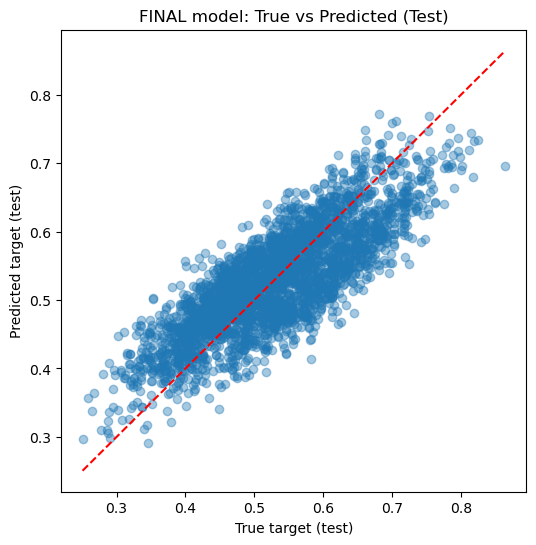

In [15]:
# ============================================================
# SECTION 5: VISUALIZATIONS (with FINAL model)
# Use TEST for unbiased visual diagnostics
# ============================================================
# True vs Predicted (TEST)
plt.figure(figsize=(6, 6))
plt.scatter(y_test, test_pred_final, alpha=0.4)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         "r--")
plt.xlabel("True target (test)")
plt.ylabel("Predicted target (test)")
plt.title("FINAL model: True vs Predicted (Test)")
plt.show()


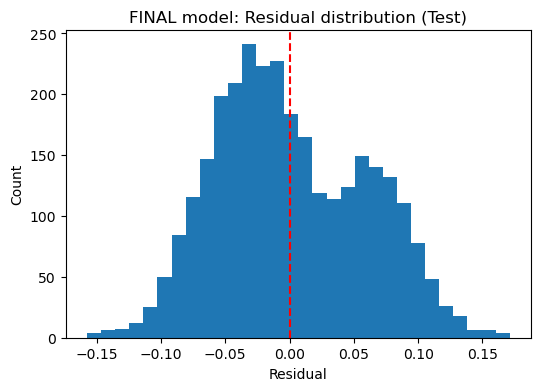

In [16]:
# Residuals (TEST)
test_residuals = y_test - test_pred_final

plt.figure(figsize=(6, 4))
plt.hist(test_residuals, bins=30)
plt.axvline(0, color="red", linestyle="--")
plt.title("FINAL model: Residual distribution (Test)")
plt.xlabel("Residual")
plt.ylabel("Count")
plt.show()


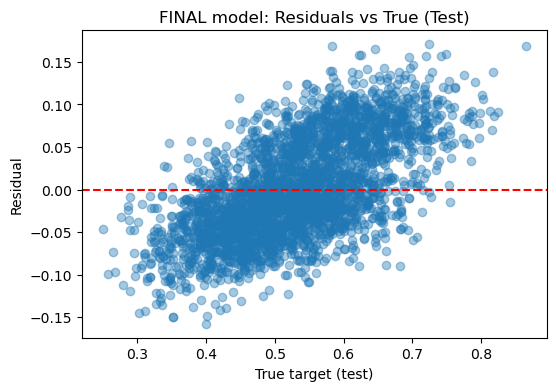

In [17]:
plt.figure(figsize=(6, 4))
plt.scatter(y_test, test_residuals, alpha=0.4)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("True target (test)")
plt.ylabel("Residual")
plt.title("FINAL model: Residuals vs True (Test)")
plt.show()

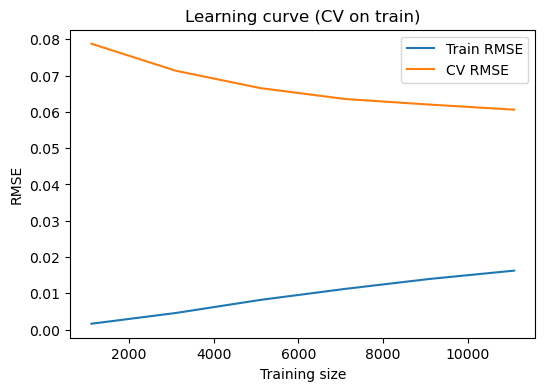

In [18]:
# Learning curve (on TRAIN only; CV inside)
est_for_curve = XGBRegressor(
    **best_params,
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1
)

train_sizes, train_scores, val_scores = learning_curve(
    est_for_curve,
    X_train_enc,
    y_train,
    cv=5,
    scoring="neg_mean_squared_error",
    train_sizes=np.linspace(0.1, 1.0, 6),
    n_jobs=-1
)

train_rmse_curve = np.sqrt(-train_scores.mean(axis=1))
val_rmse_curve   = np.sqrt(-val_scores.mean(axis=1))

plt.figure(figsize=(6, 4))
plt.plot(train_sizes, train_rmse_curve, label="Train RMSE")
plt.plot(train_sizes, val_rmse_curve, label="CV RMSE")
plt.xlabel("Training size")
plt.ylabel("RMSE")
plt.title("Learning curve (CV on train)")
plt.legend()
plt.show()

#### Save the model and encoder

In [19]:
joblib.dump(preprocess, "encoder.pkl")
joblib.dump(final_model, "models/workout_model.pkl")

['models/workout_model.pkl']

### Create testing data

In [ ]:
user = user.drop(
                    columns=['Age', 'Goal', 'WeightChange (kg)', 'GoalDays', 'BMR', 'PAL', 'TDEE', 'CalorieChange', 'CaloriesToBurnTraining', 
                        'CaloriesReducedFromFood', 'CaloriesPerDay',  'TotalWorkouts', 'CaloriesPerWorkout', "BMI"]
                )

In [21]:
user

,Gender,Weight (kg),Height (m),BMI,Experience_Level,Workout_Frequency (days),Daily meals frequency,diet_type,cluster_id
0,Male,88.0,1.8,27.160494,2,3,3,Keto,0


In [22]:
# Exercise-related features
exercise_df = df[
                    ['Sets', 'Reps', 'rating', 'workload', 'Workout_Type', 'Name of Exercise', 'Benefit',
                        'Target Muscle Group', 'Equipment Needed', 'Body Part',
                        'Type of Muscle', 'Workout' ]
].reset_index(drop=True)

# Repeat user row to match number of exercises 
workout_predict = pd.concat(
    [pd.concat([user] * len(exercise_df), ignore_index=True), exercise_df],
    axis=1
)

workout_predict.head(3)

,Gender,Weight (kg),Height (m),BMI,Experience_Level,Workout_Frequency (days),Daily meals frequency,diet_type,cluster_id,Sets,Reps,rating,workload,Workout_Type,Name of Exercise,Benefit,Target Muscle Group,Equipment Needed,Body Part,Type of Muscle,Workout
0,Male,88.0,1.8,27.160494,2,3,3,Keto,0,5,21,1.31,105,Strength,Decline Push-ups,Improves shoulder health and posture,"Shoulders, Triceps",Cable Machine,Legs,Lats,Dumbbell flyes
1,Male,88.0,1.8,27.160494,2,3,3,Keto,0,4,16,1.92,64,HIIT,Bear Crawls,Strengthens lower abs,"Back, Core, Shoulders",Step or Box,Chest,Lats,Lateral raises
2,Male,88.0,1.8,27.160494,2,3,3,Keto,0,5,22,4.70,110,Cardio,Dips,Builds chest strength,"Quadriceps, Glutes",Step or Box,Arms,Grip Strength,Standing calf raises


In [ ]:
preprocess = joblib.load("encoder.pkl")
final_model = joblib.load("models/workout_model.pkl")

workout_predict_enc = preprocess.transform(workout_predict)
predictions = final_model.predict(workout_predict_enc)

In [24]:
# Add predictions as a new column
workout_predict = workout_predict.copy()
workout_predict["workout_score"] = predictions


workout_predict.head(3)

,Gender,Weight (kg),Height (m),BMI,Experience_Level,Workout_Frequency (days),Daily meals frequency,diet_type,cluster_id,Sets,Reps,rating,workload,Workout_Type,Name of Exercise,Benefit,Target Muscle Group,Equipment Needed,Body Part,Type of Muscle,Workout,workout_score
0,Male,88.0,1.8,27.160494,2,3,3,Keto,0,5,21,1.31,105,Strength,Decline Push-ups,Improves shoulder health and posture,"Shoulders, Triceps",Cable Machine,Legs,Lats,Dumbbell flyes,0.521279
1,Male,88.0,1.8,27.160494,2,3,3,Keto,0,4,16,1.92,64,HIIT,Bear Crawls,Strengthens lower abs,"Back, Core, Shoulders",Step or Box,Chest,Lats,Lateral raises,0.491490
2,Male,88.0,1.8,27.160494,2,3,3,Keto,0,5,22,4.70,110,Cardio,Dips,Builds chest strength,"Quadriceps, Glutes",Step or Box,Arms,Grip Strength,Standing calf raises,0.515867


#### Top 100 most suitable exercises based on user profile and goal & Recommendation system

Why this is “classical recommender way”

This matches standard recommender architecture:

1) Candidate generation

Top-100 by predicted relevance (workout_score)

2) Content embedding

TF-IDF vectors from exercise metadata

3) Similarity-based grouping

Cosine similarity to “day prototypes” (a standard content-based trick)

4) Reranking for diversity

MMR is a classic diversification algorithm used in recommender systems.

In [25]:
# ----------------------------
# 1) Candidate generation: Top N
# ----------------------------
TOP_N = 100
candidates = (
    workout_predict
    .sort_values("workout_score", ascending=False)
    .head(TOP_N)
    .reset_index(drop=True)
    .copy()
)
                       
                        
# ----------------------------
# 2) Build text for vectorization (classic content-based)
# ----------------------------
TEXT_COLS = ["Benefit", "Target Muscle Group", "Equipment Needed", "Workout", "Body Part", "Type of Muscle", "Workout_Type", "Name of Exercise"]

def make_text_profile(df: pd.DataFrame, cols=TEXT_COLS) -> pd.Series:
    tmp = df[cols].copy()
    for c in cols:
        tmp[c] = (tmp[c].astype(str).fillna("")
                  .str.lower()
                  .str.replace(r"\s+", " ", regex=True)
                  .str.strip())
    return tmp.apply(lambda r: " ".join([v for v in r.values if v and v != "nan"]), axis=1)

exercise_text = make_text_profile(candidates)

# TF-IDF vectors for exercises
vectorizer = TfidfVectorizer(ngram_range=(1, 2), min_df=1, max_features=5000)
X_ex = vectorizer.fit_transform(exercise_text)

# ----------------------------
# 3) Create "day prototypes" as text -> vector 
# ----------------------------
day_prototypes = {
    "Legs": "legs lower body quads quadriceps hamstrings glutes calves posterior",
    "Push": "chest shoulders triceps upper chest pressing push",
    "Pull": "back lats upper back biceps rows pull",
    "Core": "abs core obliques plank dead bug flutter kicks",
}

proto_text = list(day_prototypes.values())
X_proto = vectorizer.transform(proto_text)  # same vector space

# similarity of each exercise to each day prototype
S_day = cosine_similarity(X_ex, X_proto)   # shape: (n_exercises, 4)

day_names = list(day_prototypes.keys())
candidates["day_label"] = [day_names[i] for i in np.argmax(S_day, axis=1)]
candidates["day_sim"] = np.max(S_day, axis=1)  # confidence (how strongly it matches)

# ----------------------------
# 4) MMR reranking: relevant + diverse inside each day
# ----------------------------
def mmr_select(df_day: pd.DataFrame,
               X_day_vecs,
               k: int = 6,
               alpha: float = 0.7):
    """
    Classic MMR:
      score(item) = alpha * relevance(item) - (1-alpha) * max_sim(item, selected)
    where relevance = workout_score (you can also include day_sim if you want).
    """
    if len(df_day) == 0:
        return df_day

    # normalize relevance to 0..1 for stable mixing
    rel = df_day["workout_score"].to_numpy()
    rel = (rel - rel.min()) / (rel.max() - rel.min() + 1e-9)

    selected_idx = []
    remaining = list(range(len(df_day)))

    # Precompute cosine sims within the day candidate set
    sims = cosine_similarity(X_day_vecs, X_day_vecs)

    while remaining and len(selected_idx) < min(k, len(df_day)):
        if not selected_idx:
            # pick highest relevance first
            best = remaining[int(np.argmax(rel[remaining]))]
        else:
            mmr_scores = []
            for i in remaining:
                max_sim_to_selected = np.max(sims[i, selected_idx])
                mmr = alpha * rel[i] - (1 - alpha) * max_sim_to_selected
                mmr_scores.append(mmr)
            best = remaining[int(np.argmax(mmr_scores))]

        selected_idx.append(best)
        remaining.remove(best)

    return df_day.iloc[selected_idx].copy()

# ----------------------------
# 5) Build a daily plan: each day different, each internally balanced
# ----------------------------
EXERCISES_PER_DAY = 6
alpha = 0.75  # higher => more relevance; lower => more diversity

plan = {}
for day in day_names:
    df_day = candidates[candidates["day_label"] == day].copy()
    if len(df_day) == 0:
        plan[day] = df_day
        continue

    # get vectors corresponding to rows in df_day (same indices as candidates)
    idx = df_day.index.to_numpy()
    X_day = X_ex[idx]

    # MMR selection inside that day
    plan[day] = mmr_select(df_day, X_day, k=EXERCISES_PER_DAY, alpha=alpha)

# ----------------------------
# 6) Display / output
# ----------------------------
cols_show = ['Workout_Type', 'Workout', 'workload', 'Name of Exercise', 'Body Part', 'Target Muscle Group', 'Equipment Needed', 'Sets', 'Reps', 'Type of Muscle', 'Benefit', 'rating', 
                         ]

for day in day_names:
    print(f"\n===== {day} Day =====")
    display(plan[day][cols_show].reset_index(drop=True))



===== Legs Day =====


,Workout_Type,Workout,workload,Name of Exercise,Body Part,Target Muscle Group,Equipment Needed,Sets,Reps,Type of Muscle,Benefit,rating
0,HIIT,Bent-over rows,115,Calf Raises,Abs,"Back, Hamstrings, Glutes",None or Dumbbells,5,23,Anterior,Builds shoulder width,4.52
1,HIIT,Cable crossovers,115,Face Pulls,Legs,"Glutes, Hamstrings, Core",Parallel Bars or Chair,5,23,Lower Chest,Combines lower body and upper body strength,3.71
2,HIIT,Face pulls,120,Thrusters,Chest,Calves,Bench or Chair,5,24,Posterior,Builds unilateral leg strength,2.71
3,HIIT,Cable crossovers,125,Russian Twists,Forearms,"Quadriceps, Calves, Glutes",Barbell,5,25,Posterior,Improves shoulder mobility and posture,4.71
4,HIIT,Incline cable crossovers,105,Wall Angels,Arms,"Quadriceps, Hamstrings, Glutes",Parallel Bars or Chair,5,21,Wrist Flexors,Strengthens core and improves mobility,1.30
5,HIIT,Face pulls,115,Prone Cobras,Chest,"Glutes, Hamstrings","Bench, Barbell",5,23,Posterior,Strengthens core and improves mobility,4.47



===== Push Day =====


,Workout_Type,Workout,workload,Name of Exercise,Body Part,Target Muscle Group,Equipment Needed,Sets,Reps,Type of Muscle,Benefit,rating
0,HIIT,Barbell hip thrusts,125,Dips,Abs,Triceps,Parallel Bars or Chair,5,25,Wrist Flexors,Builds shoulder width,1.22
1,HIIT,Donkey kicks,100,Decline Push-ups,Abs,"Back, Core, Shoulders",Box or Platform,5,20,Wrist Extensors,Improves posture and back strength,0.97
2,HIIT,Incline dumbbell flyes,115,Face Pulls,Arms,"Chest, Triceps",Dumbbells,5,23,Anterior,Strengthens triceps and chest,4.48
3,Cardio,Crunches,105,Frog Jumps,Shoulders,"Quadriceps, Glutes",Bench or Sturdy Surface,5,21,Triceps,Full body workout,2.46
4,Cardio,Chest flyes,105,Squats,Legs,"Chest, Triceps",Parallel Bars or Chair,5,21,Grip Strength,Improves hip power and cardiovascular fitness,1.22
5,HIIT,Dumbbell curls,105,Lat Pulldowns,Chest,"Back, Core, Shoulders",Dumbbells or Barbell,5,21,Grip Strength,Targets lower abs,1.17



===== Pull Day =====


,Workout_Type,Workout,workload,Name of Exercise,Body Part,Target Muscle Group,Equipment Needed,Sets,Reps,Type of Muscle,Benefit,rating
0,HIIT,Barbell curls,95,Tricep Dips,Shoulders,"Back, Core, Shoulders",Wall,5,19,Grip Strength,Strengthens back and legs,2.61
1,HIIT,Hanging leg raises,95,Calf Raises,Shoulders,"Shoulders, Upper Back",Parallel Bars or Chair,5,19,Anterior,Builds unilateral leg strength and balance,2.47
2,HIIT,Lateral raises,125,Bench Press,Abs,"Back, Biceps",Low Bar or TRX,5,25,Quads,Improves core stability and balance,4.20
3,HIIT,Standing calf raises,105,Jumping Jacks,Legs,"Back, Biceps",Bench or Step,5,21,Lateral,Strengthens lower body,1.28
4,Yoga,Overhead triceps extensions,125,Seated Rows,Chest,"Upper Back, Rear Deltoids",Pull-up Bar,5,25,Anterior,Builds explosive power,4.21
5,HIIT,Decline dumbbell flyes,115,Lateral Raises,Shoulders,"Shoulders, Upper Back",Resistance Band or Cable Machine,5,23,Posterior,Strengthens back and improves posture,3.09



===== Core Day =====


,Workout_Type,Workout,workload,Name of Exercise,Body Part,Target Muscle Group,Equipment Needed,Sets,Reps,Type of Muscle,Benefit,rating
0,Yoga,Leg curls,120,Lateral Raises,Arms,Triceps,Wall,5,24,Grip Strength,Targets obliques and improves core rotation,4.92
1,HIIT,Hammer curl,95,Plank,Abs,"Full Body, Core, Shoulders",Parallel Bars or Chair,5,19,Lower,Builds calf muscles,2.61
2,Strength,Cable crossovers,115,Flutter Kicks,Legs,"Glutes, Hamstrings",None or Dumbbells,5,23,Wrist Flexors,Activates and strengthens glutes,2.71
3,HIIT,Dumbbell front raises,115,Box Jumps,Arms,Core,Bench or Step,5,23,Wrist Flexors,Strengthens core and improves mobility,4.50
4,Strength,Standing calf raises,105,Bulgarian Split Squats,Arms,"Core, Obliques",Pull-up Bar,5,21,Grip Strength,Builds upper body strength,3.09
5,HIIT,Military press,100,Zottman Curls,Arms,"Legs, Shoulders, Core",None or Dumbbells,5,20,Wrist Flexors,Targets obliques and improves core rotation,1.07


Exception ignored in: <function ResourceTracker.__del__ at 0x1075e9bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x104355bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x105165bc0>
Traceback (most recent call last